## Merge features to produce final dataset for training, validation and test

In [1]:
import pandas as pd
import ast
import numpy as np
import matplotlib.pyplot as plt
import sys
import gc
from tqdm import tqdm
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
sys.modules["numpy._core.numeric"] = np.core.numeric

### Train-test split and encoding for physiochemical

In [2]:
fe_df = pd.read_csv("../dataset/physiochemical/output_results.csv")
fe_df

,Original,AAC,DC,molecular_weight,isoelectric_point,gravy,aromaticity,instability_index,aliphatic_index,boman_index
0,MQAKILRIATRKSPLAICQACYVCNKLKHYHPHIQTELIPIITTGD...,"[0.0707395498392283, 0.02572347266881029, 0.04...","[0.0, 0.0032258064516129032, 0.003225806451612...",35011.6433,9.364049,-0.041479,0.051447,38.157235,116.720257,0.359100
1,MKKLRIGARDSKLSRIQVDIVARKIKQTLGIECEFVPIKTKGDIDK...,"[0.05517241379310345, 0.02413793103448276, 0.0...","[0.0034602076124567475, 0.0, 0.003460207612456...",32275.0348,8.347963,-0.154483,0.058621,42.982793,105.862069,0.291586
2,MKKELIIGTRSSPLALWQAEFTKAELSRHFPELNITLKLVKTTGDV...,"[0.07051282051282051, 0.01282051282051282, 0.0...","[0.0, 0.0, 0.003215434083601286, 0.02250803858...",34393.4749,6.042860,-0.122436,0.044872,40.237821,101.923077,0.262981
3,MFNRQASGGAGSSGQGAGSSQTASAAPVSAGVGVGGGGGASGAAAG...,"[0.09324104234527687, 0.023615635179153095, 0....","[0.010792099368764, 0.0030543677458766036, 0.0...",529990.8042,6.424364,-0.162032,0.053542,46.634426,90.848941,0.260615
4,MPSESFCLAAQARLDSKWLKTDIQLAFTRDGLCGLWNEMVKDGEIV...,"[0.07840297889946214, 0.02399669011170873, 0.0...","[0.008069522036002483, 0.0028967515001034555, ...",527221.8439,5.875981,-0.186202,0.060612,42.951614,90.877120,0.276119
...,...,...,...,...,...,...,...,...,...,...
110217,MVRTRLAISVVLVSTLLLLNVKAKSVDPYKVLGVSKDAKQREIQKA...,"[0.050699300699300696, 0.008741258741258742, 0...","[0.0035026269702276708, 0.0, 0.0, 0.0070052539...",62569.2650,9.518709,-0.490559,0.089161,38.246521,72.237762,0.166154
110218,MPKAPKQQPPEPEWIGDGESTSPSDKVVKKGKKDKKIKKTFFEELA...,"[0.07558859975216853, 0.009913258983890954, 0....","[0.009925558312655087, 0.0012406947890818859, ...",91651.1398,7.208401,-0.883643,0.055762,47.106072,74.361834,0.030607
110219,MTDPHTARTIVGIVGNVISFGLFCAPIPTMVKIWKMKSVSEFKPDP...,"[0.05, 0.020833333333333332, 0.033333333333333...","[0.0041841004184100415, 0.0041841004184100415,...",27209.3824,8.883244,0.681667,0.137500,34.603792,111.583333,0.752250
110220,MAVPASPQHPRGYGILLLTLLLKALATTASACNHLRPQDATFSHDS...,"[0.07772020725388601, 0.031088082901554404, 0....","[0.0, 0.010416666666666666, 0.0052083333333333...",22115.7405,9.055116,-0.532124,0.067358,65.206218,81.502591,0.197876


In [3]:
train_df = pd.read_csv("../dataset/ec40/train.csv")
valid_df = pd.read_csv("../dataset/ec40/valid.csv")
test_df = pd.read_csv("../dataset/ec40/test.csv")

In [4]:
fe_train = fe_df[fe_df['Original'].isin(train_df['sequence'])]
fe_test  = fe_df[fe_df['Original'].isin(test_df['sequence'])]
fe_valid = fe_df[fe_df['Original'].isin(valid_df['sequence'])]
train_df = train_df.merge(fe_train, left_on='sequence', right_on='Original', how='left')
test_df  = test_df.merge(fe_test, left_on='sequence', right_on='Original', how='left')
valid_df = valid_df.merge(fe_valid, left_on='sequence', right_on='Original', how='left')

In [5]:
def encode_ec_vector(x):
    if isinstance(x, str):
        try:
            parsed = ast.literal_eval(x)
            if isinstance(parsed, list):
                x = parsed[0]
            else:
                x = parsed
        except Exception:
            pass
    if isinstance(x, str):
        parts = x.split('.')
    else:
        parts = []

    vec = []
    for part in parts:
        part = part.strip()
        if part == '-' or part == '':
            vec.append(-1)
        else:
            try:
                vec.append(int(part))
            except ValueError:
                try:
                    vec.append(float(part))
                except Exception:
                    vec.append(-1)
    return vec

def convert_str_to_list(x):
    if isinstance(x, str):
        try:
            return ast.literal_eval(x)
        except Exception:
            return x
    return x

def expand_column(df, column_names, drop_original=False):

    for column_name in column_names:
        expanded_cols = df[column_name].apply(pd.Series)
        expanded_cols.columns = [f"{column_name}_{i}" for i in expanded_cols.columns]
        df = pd.concat([df, expanded_cols], axis=1)
        if drop_original:
            df = df.drop(columns=[column_name])
    return df

In [6]:
train_df['ec'] = pd.Series([encode_ec_vector(x) for x in train_df['ec']], index=train_df.index)
valid_df['ec'] = pd.Series([encode_ec_vector(x) for x in valid_df['ec']], index=valid_df.index)
test_df['ec']  = pd.Series([encode_ec_vector(x) for x in test_df['ec']],  index=test_df.index)

In [7]:
cols_to_convert = ['AAC', 'DC']
for col in cols_to_convert:
    train_df[col] = pd.Series([convert_str_to_list(x) for x in train_df[col]], index=train_df.index)
    valid_df[col] = pd.Series([convert_str_to_list(x) for x in valid_df[col]], index=valid_df.index)
    test_df[col]  = pd.Series([convert_str_to_list(x) for x in test_df[col]],  index=test_df.index)

In [8]:
train_df = expand_column(train_df, ['ec', 'AAC', 'DC'], True)
valid_df = expand_column(valid_df, ['ec', 'AAC', 'DC'], True)
test_df = expand_column(test_df, ['ec', 'AAC', 'DC'], True)

### Add HMM Features

In [9]:
def merge_hmm(df, flag="train"):
    feature_df = pd.read_csv(f"../dataset/HMM/{flag}_features.csv")
    final_df = pd.merge(df, feature_df, left_on='accession',right_on='query_name', how="left").fillna(0)
    return final_df

train_df = merge_hmm(train_df, "train")
valid_df = merge_hmm(valid_df, "valid")
test_df = merge_hmm(test_df, "test")

In [10]:
train_df

,accession,sequence,traintest,negative_for,mainclass_set,sprot_version,len,cluster_ID,representative,Original,...,DC_395,DC_396,DC_397,DC_398,DC_399,query_name,E-value,score,coverage,num_domains
0,A4XK06,MKKLRIGARDSKLSRIQVDIVARKIKQTLGIECEFVPIKTKGDIDK...,0,0.0,Transferases,2017_03,1,cdhit40.fasta_171115,False,MKKLRIGARDSKLSRIQVDIVARKIKQTLGIECEFVPIKTKGDIDK...,...,0.000000,0.000000,0.000000,0.000000,0.000000,A4XK06,2.900000e-71,27.0,0.920690,2.0
1,Q9VR91,MFNRQASGGAGSSGQGAGSSQTASAAPVSAGVGVGGGGGASGAAAG...,0,0.0,Transferases,2017_03,1,cdhit40.fasta_134383,True,MFNRQASGGAGSSGQGAGSSQTASAAPVSAGVGVGGGGGASGAAAG...,...,0.001425,0.001833,0.001629,0.000204,0.000407,Q9VR91,3.000000e-03,717.7,0.476181,57.0
2,O95714,MPSESFCLAAQARLDSKWLKTDIQLAFTRDGLCGLWNEMVKDGEIV...,0,0.0,Transferases,2017_03,1,cdhit40.fasta_42431,False,MPSESFCLAAQARLDSKWLKTDIQLAFTRDGLCGLWNEMVKDGEIV...,...,0.001862,0.002069,0.000621,0.000207,0.000207,O95714,4.200000e-02,9.5,0.650393,89.0
3,O66129,MIALSYKAFLNPYIIEVEKRLYECIQSDSETINKAAHHILSSGGKR...,0,0.0,Transferases,2017_03,1,cdhit40.fasta_79215,True,MIALSYKAFLNPYIIEVEKRLYECIQSDSETINKAAHHILSSGGKR...,...,0.000000,0.003086,0.000000,0.000000,0.000000,O66129,1.400000e-04,227.6,1.064615,4.0
4,Q68CP4,MTGARASAAEQRRAGRSGQARAAERAAGMSGAGRALAALLLAASVL...,0,0.0,Transferases,2017_03,1,cdhit40.fasta_263145,True,MTGARASAAEQRRAGRSGQARAAERAAGMSGAGRALAALLLAASVL...,...,0.001511,0.000000,0.003021,0.003021,0.001511,Q68CP4,8.400000e-03,30.3,0.506787,5.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45755,Q5UPX0,MDDYEKSKVLTKRYKKLKKLLKMVYGYDNFRPRQYEIINKVINGED...,0,0.0,Hydrolases,2017_03,1,cdhit40.fasta_55008,True,MDDYEKSKVLTKRYKKLKKLLKMVYGYDNFRPRQYEIINKVINGED...,...,0.000000,0.000000,0.003656,0.000000,0.003656,Q5UPX0,1.200000e-05,81.3,1.312044,9.0
45756,Q5UR49,MSLVPKAGYPFIIYFLDNINKYISDKTIQTYLTAFQINVDNLKVIN...,0,0.0,Hydrolases,2017_03,1,cdhit40.fasta_514766,True,MSLVPKAGYPFIIYFLDNINKYISDKTIQTYLTAFQINVDNLKVIN...,...,0.001441,0.000000,0.001441,0.000000,0.002882,Q5UR49,6.900000e-04,92.2,2.138129,21.0
45757,P64636,MHINIAWQDVDTVLLDMDGTLLDLAFDNYFWQKLVPETWGAKNGVT...,0,0.0,Hydrolases,2017_03,1,cdhit40.fasta_36634,True,MHINIAWQDVDTVLLDMDGTLLDLAFDNYFWQKLVPETWGAKNGVT...,...,0.000000,0.000000,0.000000,0.004525,0.000000,P64636,8.100000e-04,77.9,2.729730,6.0
45758,P94559,MNVLIISDSHGLEEELQTIAKRHEAEVDLMIHCGDSELETRHPALE...,0,0.0,Hydrolases,2017_03,1,cdhit40.fasta_533178,True,MNVLIISDSHGLEEELQTIAKRHEAEVDLMIHCGDSELETRHPALE...,...,0.000000,0.000000,0.000000,0.000000,0.005952,P94559,1.100000e-01,37.6,1.928994,3.0


### Split and Add peptides features

In [11]:
pp_df = pd.read_csv("../dataset/peptides/seq_feats.csv")
pp_df = pp_df.drop(columns=['Unnamed: 0'])

In [12]:
pp_df['data'] = pp_df['data'].apply(lambda s: eval(s, {"np": np}))
pp_df['data_dict'] = pp_df['data'].apply(lambda x: x[0] if isinstance(x, list) and len(x) > 0 else {})
data_expanded = pp_df['data_dict'].apply(pd.Series)
pp_df = pd.concat([pp_df, data_expanded], axis=1)
pp_df.drop(columns=['data', 'data_dict'], inplace=True)
pp_df = pp_df.drop_duplicates(subset='accession', keep='first')
pp_df

,accession,AF1,AF2,AF3,AF4,AF5,BLOSUM1,BLOSUM2,BLOSUM3,BLOSUM4,...,VSTPV2,VSTPV3,VSTPV4,VSTPV5,VSTPV6,Z1,Z2,Z3,Z4,Z5
0,Q7VRM4,-0.029281,-0.096226,-0.116617,0.355304,0.013183,0.046045,-0.311190,-0.251190,0.042540,...,0.136302,0.420418,-0.278006,0.169357,-0.133891,-0.090675,-0.511543,-0.505498,-0.362797,0.305659
1,A4XK06,0.031880,-0.077574,-0.360039,0.377882,-0.194147,0.144586,-0.305724,-0.199793,0.021276,...,0.198414,0.413690,-0.335655,0.229759,-0.193793,0.191931,-0.526621,-0.395103,-0.531103,0.289207
2,Q8KCJ4,0.000600,-0.117652,-0.161189,0.459098,-0.060263,0.138526,-0.330513,-0.174231,-0.037244,...,0.197628,0.442051,-0.355417,0.176282,-0.223397,0.107724,-0.648397,-0.419199,-0.496090,0.283910
3,Q9VR91,-0.069875,0.008929,-0.553377,0.458163,-0.248112,0.162258,-0.265145,-0.061735,-0.036521,...,0.087494,0.466179,-0.437199,0.225794,-0.309963,0.170827,-0.700737,-0.225900,-0.406464,0.306325
4,O95714,-0.041783,-0.000918,-0.451391,0.421223,-0.238567,0.159524,-0.267429,-0.080556,-0.024731,...,0.096173,0.443808,-0.421132,0.215689,-0.279313,0.188678,-0.649019,-0.242199,-0.456235,0.270306
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
110203,P40228,0.089087,0.136184,-0.281678,0.276177,-0.164250,0.240139,-0.140592,-0.078293,0.070732,...,0.076341,0.334077,-0.452683,0.289652,-0.232997,0.455889,-0.314216,-0.060453,-0.533693,0.187631
110205,Q8L9X2,0.072175,-0.008675,-0.057239,0.289849,0.056188,0.135665,-0.173498,-0.205961,-0.010049,...,0.164532,0.336847,-0.316897,0.236305,-0.160148,0.185961,-0.255172,-0.447783,-0.264335,0.182217
110206,Q54AX5,0.011130,-0.030923,-0.312671,0.409070,-0.216800,0.128902,-0.324157,-0.250333,-0.015706,...,0.170039,0.402863,-0.299765,0.151412,-0.159196,-0.161608,-0.485118,-0.383902,-0.661588,0.472235
110218,Q7YR37,0.277529,-0.177994,-0.164657,0.327573,-0.084777,0.372825,-0.186022,-0.241475,-0.139554,...,0.232639,0.335440,-0.380099,0.272131,-0.207881,0.557708,-0.319343,-0.476357,-0.481772,0.315167


In [13]:
pp_train = pp_df[pp_df['accession'].isin(train_df['accession'])]
pp_test  = pp_df[pp_df['accession'].isin(test_df['accession'])]
pp_valid = pp_df[pp_df['accession'].isin(valid_df['accession'])]
train_df = train_df.merge(pp_train, left_on='accession', right_on='accession', how='left')
test_df  = test_df.merge(pp_test, left_on='accession', right_on='accession', how='left')
valid_df = valid_df.merge(pp_valid, left_on='accession', right_on='accession', how='left')

### Apply PCA to PSSM and merge PSSM

In [14]:
train_pssm = pd.read_pickle('../dataset/pssm/train_pssms.pkl')

In [15]:
valid_pssm = pd.read_pickle('../dataset/pssm/valid_pssms.pkl')
test_pssm = pd.read_pickle('../dataset/pssm/test_pssms.pkl')

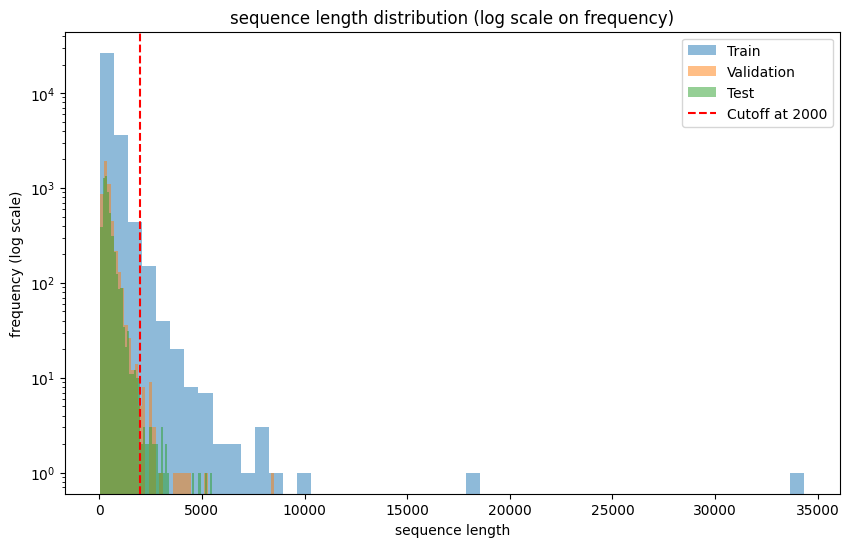

In [16]:
def get_m_values(df, matrix_column='pssm_matrix'):
    return df[matrix_column].apply(lambda mat: mat.shape[0])

train_m = get_m_values(train_pssm, matrix_column='pssm_matrix')
valid_m = get_m_values(valid_pssm, matrix_column='pssm_matrix')
test_m  = get_m_values(test_pssm, matrix_column='pssm_matrix')

plt.figure(figsize=(10, 6))
plt.hist(train_m, bins=50, alpha=0.5, label='Train')
plt.hist(valid_m, bins=50, alpha=0.5, label='Validation')
plt.hist(test_m,  bins=50, alpha=0.5, label='Test')
plt.axvline(x=2000, color='red', linestyle='--', linewidth=1.5, label='Cutoff at 2000')

plt.yscale('log')
plt.xlabel("sequence length")
plt.ylabel("frequency (log scale)")
plt.title("sequence length distribution (log scale on frequency)")
plt.legend()
plt.savefig("../metrics/sequence_length_distribution.png", dpi=300, bbox_inches='tight')
plt.show()

In [17]:
def truncate_and_flatten(matrix, target_rows=2000, n_cols=42):
    matrix = np.array(matrix, dtype=np.float32) # reduce memory usage
    m = matrix.shape[0]
    if m < target_rows:
        pad = np.zeros((target_rows - m, n_cols), dtype=np.float32)
        matrix = np.vstack([matrix, pad])
    else:
        matrix = matrix[:target_rows, :n_cols]
    return matrix.flatten()

In [18]:
# Use list comprehension instead of apply for better performance
features_list = [truncate_and_flatten(x, target_rows=2000, n_cols=42) 
                 for x in train_pssm['pssm_matrix']]

features_matrix = np.stack(features_list)
pca = PCA(n_components=8400, svd_solver='randomized', random_state=42)
features_reduced = pca.fit_transform(features_matrix)
new_train_pssm = pd.DataFrame(features_reduced, columns=[f'pssm_{i}' for i in range(features_reduced.shape[1])])
new_train_pssm.insert(0, 'accession', train_pssm['accession_id'].values)
new_train_pssm

,accession,pssm_0,pssm_1,pssm_2,pssm_3,pssm_4,pssm_5,pssm_6,pssm_7,pssm_8,...,pssm_8390,pssm_8391,pssm_8392,pssm_8393,pssm_8394,pssm_8395,pssm_8396,pssm_8397,pssm_8398,pssm_8399
0,U3NEE3,-120.660194,0.051137,55.270844,60.649765,5.291504,-67.024208,-65.270424,-72.827400,13.192751,...,-4.445078,-4.961411,5.561345,0.970937,2.802726,4.433674,4.137346,-2.474319,12.130609,-1.765741
1,Q8ZY40,-216.212097,-137.700897,-76.713181,-44.094463,-13.020007,16.171223,16.057438,44.263603,5.095284,...,-0.373057,-3.096987,4.946281,-1.204419,-1.080940,-1.892168,-1.018403,-0.621847,-3.140903,-0.765614
2,A7GDQ1,-207.097168,-120.301720,-54.175518,-16.252760,19.323286,41.162445,-13.954965,57.507496,-5.822147,...,0.413233,-0.033141,3.432824,-0.085269,-1.097159,0.529198,2.330125,-1.334794,0.612982,-1.166477
3,Q68CP4,230.459610,110.231285,-117.797783,-14.629717,116.484673,2.393157,70.747192,-21.925442,-23.373207,...,3.277350,-0.839878,3.580122,6.518913,6.229023,-8.775028,-5.332768,1.661868,-2.119514,-7.481851
4,Q4JW55,-190.031296,-91.646202,-21.232416,16.345018,39.389965,46.857826,-18.096468,-0.254254,21.463160,...,7.792313,-2.307057,1.239090,-6.391222,-3.401621,-1.392195,-5.109597,0.825560,0.889808,-3.716059
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30962,Q12697,574.659851,-346.204559,184.372177,-67.794266,-23.860882,23.374760,0.403564,-121.231682,-74.880592,...,-15.353306,0.607883,3.440179,11.460594,6.032447,-10.955040,-2.894092,-0.807956,2.033595,5.558188
30963,Q09449,565.192810,-354.502441,228.322983,-115.859123,-5.555195,3.395013,-33.297810,-70.565147,-60.414383,...,1.163340,-1.317358,-4.082357,5.827973,9.883329,5.991320,9.574036,-4.717540,0.533056,-4.629128
30964,P0C7L7,588.500427,-357.051697,241.480408,-110.623413,22.948242,24.533123,0.310333,-16.258856,-109.280167,...,-15.565695,-4.226551,-15.522315,-5.214865,8.503365,-0.692089,0.697770,3.687022,-1.450869,-0.500555
30965,Q97T80,616.990540,-421.822479,332.649658,-205.436661,143.760742,-79.002594,-20.105658,105.341705,-41.447220,...,5.784378,-4.591341,-10.536043,-0.627940,0.830679,0.013324,7.339062,-0.341808,1.599806,-0.325540


In [19]:
accession = valid_pssm['accession_id'].values
features_matrix = np.stack([truncate_and_flatten(x, 2000, 42) for x in valid_pssm['pssm_matrix']])

valid_features = pca.transform(features_matrix)
new_valid_pssm = pd.DataFrame(valid_features, 
                columns=[f'pssm_{i}' for i in range(valid_features.shape[1])])
new_valid_pssm.insert(0, 'accession', accession)
new_valid_pssm

,accession,pssm_0,pssm_1,pssm_2,pssm_3,pssm_4,pssm_5,pssm_6,pssm_7,pssm_8,...,pssm_8390,pssm_8391,pssm_8392,pssm_8393,pssm_8394,pssm_8395,pssm_8396,pssm_8397,pssm_8398,pssm_8399
0,O27550,-162.075043,-28.392914,46.873802,78.706383,66.754349,38.113205,-10.450302,25.875893,-37.399509,...,-4.347877,-2.633938,4.149680,-6.651065,2.524947,2.390883,5.650609,-3.746484,1.636882,-4.418254
1,Q18EV8,-165.627670,-35.263382,43.063820,75.249825,68.255585,53.994278,-16.109131,27.556709,-28.957649,...,-0.439846,6.190208,-3.266434,-1.165332,8.067373,8.215995,-2.658895,0.923015,-4.462220,0.293193
2,Q58601,-160.500198,-25.732056,51.170403,79.515282,63.302170,40.105865,-7.620239,19.465714,-30.540157,...,-1.762735,0.203133,-4.645865,-8.842733,2.122368,2.050828,1.354009,2.612130,1.774986,-1.029786
3,Q8TYD5,-164.936676,-31.962296,43.532417,77.891701,63.936218,45.673508,-6.322495,29.344620,-30.295912,...,-2.766345,-0.193194,1.418650,4.004705,-2.871979,-2.682863,-3.415493,-0.911926,1.513744,4.284427
4,C1A4M2,-157.113556,-21.565613,54.037804,83.718803,64.448151,33.468254,-8.592075,19.018410,-36.201767,...,-2.719550,1.450714,-1.434401,4.993985,3.779744,2.055652,5.766387,-5.360805,2.757898,-5.483641
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4916,A2A288,96.990753,142.498962,-34.938660,-107.006287,-2.766068,34.618828,-1.799137,-40.548878,-46.022961,...,8.911922,4.372449,7.216685,6.019936,-15.309216,4.175412,15.451099,14.379338,-0.585070,-8.725927
4917,Q5HYM0,342.847961,-24.646042,-129.673615,91.648705,0.501358,-79.089668,-14.994102,5.045555,-8.796942,...,7.493429,-5.658932,-8.277983,15.588692,15.966098,-10.574613,12.671926,-4.935524,8.909521,2.029501
4918,P54954,-187.747498,-80.398560,-2.303902,37.297478,55.438629,69.021927,-44.777317,41.956589,12.849041,...,3.993303,-1.053070,0.719401,-6.225080,2.539576,0.560482,-3.922298,-1.936767,-5.097125,-3.246323
4919,Q4WRC2,386.576660,-33.686005,-120.662598,124.781105,-12.210495,-22.746017,43.632683,36.487450,51.161648,...,49.708305,0.764360,13.905560,-4.284969,9.996567,-2.213834,15.498238,3.097858,10.527949,2.078994


In [20]:
accession = test_pssm['accession_id'].values
features_matrix = np.stack([truncate_and_flatten(x, 2000, 42) for x in test_pssm['pssm_matrix']])

test_features = pca.transform(features_matrix)
new_test_pssm = pd.DataFrame(test_features, 
               columns=[f'pssm_{i}' for i in range(test_features.shape[1])])
new_test_pssm.insert(0, 'accession', accession)
new_test_pssm

,accession,pssm_0,pssm_1,pssm_2,pssm_3,pssm_4,pssm_5,pssm_6,pssm_7,pssm_8,...,pssm_8390,pssm_8391,pssm_8392,pssm_8393,pssm_8394,pssm_8395,pssm_8396,pssm_8397,pssm_8398,pssm_8399
0,P61802,-68.239151,57.570282,64.956688,17.612320,-57.286594,-98.639755,-67.472488,-37.438686,-7.839313,...,-6.082579,2.602537,-6.431787,-5.084553,-0.949730,-3.707028,-5.182642,-12.644870,-6.246254,-6.160237
1,Q96EG1,88.864746,156.554138,-20.765060,-100.945076,1.163712,62.060471,65.498642,-73.484871,34.411678,...,13.487775,-14.821344,3.176764,-4.539529,12.162786,2.079322,4.395323,-7.770041,3.503469,7.237286
2,Q5LEQ9,-214.881348,-144.867432,-87.488129,-57.457001,-28.594131,-9.176559,-10.193077,41.105179,-18.382044,...,4.027218,-3.513722,6.255439,-0.185588,0.817283,0.621004,5.913538,-3.492194,-2.976082,-0.736511
3,P07684,-38.989792,111.692047,88.946541,2.636665,-35.865578,-9.056160,88.722214,15.786407,-0.413916,...,7.518246,2.198902,7.384826,11.704370,-0.085598,-6.625845,-1.236796,-9.291614,3.950653,-0.969531
4,Q0BZU8,-218.056732,-155.065689,-105.009323,-82.668137,-51.210972,-32.924679,17.665085,12.046379,-0.071599,...,-1.340918,1.281461,3.101487,0.318984,1.790541,0.536327,1.045755,-2.738993,3.538760,-5.500139
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5454,P34152,483.596924,-183.924957,-16.627029,93.862343,-119.963089,52.890991,-44.731823,-34.299168,-26.923260,...,-4.781532,13.805260,3.099123,17.683851,7.874567,7.506974,-4.355172,-2.490649,2.788021,33.328976
5455,F4JXF9,545.383606,-298.034058,142.748901,-23.704514,-79.647079,68.440811,-78.399429,-34.937229,-59.761475,...,-2.229033,1.002076,-7.298961,0.682771,13.519576,2.893311,0.556366,1.969268,4.633018,-6.769608
5456,Q8T1C6,-18.683868,100.560059,59.012306,-30.736656,-68.658279,-46.878899,-25.246155,-26.506149,27.231270,...,0.257928,0.696021,0.781742,2.716836,-5.329764,-15.180626,1.196909,1.596914,-16.555027,3.803389
5457,Q86HW6,319.178345,-3.100143,-122.316162,81.603539,27.490036,-72.116814,-33.676853,4.031868,79.573479,...,-7.972219,4.669955,14.322846,2.435887,0.716796,-3.072805,18.167717,-3.038092,6.225581,1.670493


In [21]:
def chunked_merge(left_df, right_df, on='accession', how='left', chunk_size=5000, show_progress=True):
    merged_chunks = []
    iterator = tqdm(range(0, len(left_df), chunk_size)) if show_progress else range(0, len(left_df), chunk_size)
    
    for start in iterator:
        end = start + chunk_size
        left_chunk = left_df.iloc[start:end]
        merged_chunk = pd.merge(left_chunk, right_df, on=on, how=how)
        merged_chunks.append(merged_chunk)
    
    merged_df = pd.concat(merged_chunks, ignore_index=True)
    
    del right_df
    gc.collect()
    
    return merged_df

In [22]:
train_df = chunked_merge(train_df, new_train_pssm)

100%|██████████| 10/10 [00:05<00:00,  1.82it/s]


In [23]:
valid_df = chunked_merge(valid_df, new_valid_pssm)

100%|██████████| 2/2 [00:00<00:00, 13.10it/s]


In [24]:
test_df = chunked_merge(test_df, new_test_pssm)

100%|██████████| 2/2 [00:00<00:00, 12.77it/s]


### Merge Sequence Embedding Features

In [25]:
emb_df = pd.read_pickle("../dataset/sequence_embedding/full_embedding.pkl")

In [26]:
train_df = chunked_merge(train_df, emb_df, on='accession', how='inner')

100%|██████████| 10/10 [00:00<00:00, 17.65it/s]


In [27]:
valid_df = chunked_merge(valid_df, emb_df, on='accession', how='inner')
test_df  = chunked_merge(test_df,  emb_df, on='accession', how='inner')

100%|██████████| 2/2 [00:00<00:00, 24.55it/s]


In [28]:
train_df

,accession,sequence,traintest,negative_for,mainclass_set,sprot_version,len,cluster_ID,representative,Original,...,embedded_310,embedded_311,embedded_312,embedded_313,embedded_314,embedded_315,embedded_316,embedded_317,embedded_318,embedded_319
0,A4XK06,MKKLRIGARDSKLSRIQVDIVARKIKQTLGIECEFVPIKTKGDIDK...,0,0.0,Transferases,2017_03,1,cdhit40.fasta_171115,False,MKKLRIGARDSKLSRIQVDIVARKIKQTLGIECEFVPIKTKGDIDK...,...,0.077558,0.001130,0.080206,-0.120248,-0.021819,0.108588,-0.067336,0.242951,-0.119197,0.037773
1,Q9VR91,MFNRQASGGAGSSGQGAGSSQTASAAPVSAGVGVGGGGGASGAAAG...,0,0.0,Transferases,2017_03,1,cdhit40.fasta_134383,True,MFNRQASGGAGSSGQGAGSSQTASAAPVSAGVGVGGGGGASGAAAG...,...,0.403116,-0.089608,0.186578,0.010732,-0.215566,0.174769,-0.092853,0.286215,-0.379856,-0.133513
2,O95714,MPSESFCLAAQARLDSKWLKTDIQLAFTRDGLCGLWNEMVKDGEIV...,0,0.0,Transferases,2017_03,1,cdhit40.fasta_42431,False,MPSESFCLAAQARLDSKWLKTDIQLAFTRDGLCGLWNEMVKDGEIV...,...,0.463706,-0.064925,0.185193,0.007096,-0.191906,0.176897,-0.081807,0.230770,-0.399050,-0.092984
3,O66129,MIALSYKAFLNPYIIEVEKRLYECIQSDSETINKAAHHILSSGGKR...,0,0.0,Transferases,2017_03,1,cdhit40.fasta_79215,True,MIALSYKAFLNPYIIEVEKRLYECIQSDSETINKAAHHILSSGGKR...,...,0.161103,-0.252514,0.264433,0.026723,0.046471,0.066783,-0.230481,0.264328,-0.078001,-0.073701
4,Q68CP4,MTGARASAAEQRRAGRSGQARAAERAAGMSGAGRALAALLLAASVL...,0,0.0,Transferases,2017_03,1,cdhit40.fasta_263145,True,MTGARASAAEQRRAGRSGQARAAERAAGMSGAGRALAALLLAASVL...,...,0.011132,0.016021,0.042952,0.004488,-0.071281,-0.026286,-0.051542,0.192327,-0.132582,0.097272
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45753,Q5UPX0,MDDYEKSKVLTKRYKKLKKLLKMVYGYDNFRPRQYEIINKVINGED...,0,0.0,Hydrolases,2017_03,1,cdhit40.fasta_55008,True,MDDYEKSKVLTKRYKKLKKLLKMVYGYDNFRPRQYEIINKVINGED...,...,0.065844,-0.071185,0.004398,0.089782,0.085072,0.080830,-0.081337,0.017376,0.091580,0.110881
45754,Q5UR49,MSLVPKAGYPFIIYFLDNINKYISDKTIQTYLTAFQINVDNLKVIN...,0,0.0,Hydrolases,2017_03,1,cdhit40.fasta_514766,True,MSLVPKAGYPFIIYFLDNINKYISDKTIQTYLTAFQINVDNLKVIN...,...,0.118473,-0.073835,0.109910,-0.017249,0.112124,0.118456,-0.247594,-0.068235,0.097841,0.030447
45755,P64636,MHINIAWQDVDTVLLDMDGTLLDLAFDNYFWQKLVPETWGAKNGVT...,0,0.0,Hydrolases,2017_03,1,cdhit40.fasta_36634,True,MHINIAWQDVDTVLLDMDGTLLDLAFDNYFWQKLVPETWGAKNGVT...,...,-0.181827,-0.215590,-0.082239,0.226231,-0.038157,-0.228071,-0.231707,0.206144,-0.119251,-0.098354
45756,P94559,MNVLIISDSHGLEEELQTIAKRHEAEVDLMIHCGDSELETRHPALE...,0,0.0,Hydrolases,2017_03,1,cdhit40.fasta_533178,True,MNVLIISDSHGLEEELQTIAKRHEAEVDLMIHCGDSELETRHPALE...,...,-0.021627,0.009841,-0.175546,0.175375,0.130308,-0.209561,0.015507,0.200322,0.097205,-0.091654


### Drop unnecessary columns

In [29]:
drop_columns=['Original', 'traintest', 'negative_for', 'mainclass_set', 'sprot_version', 'len', 'cluster_ID', 'representative', 'sequence', 'accession', 'query_name']

In [30]:
train_df = train_df.drop(columns=drop_columns)

In [31]:
valid_df = valid_df.drop(columns=drop_columns)
test_df = test_df.drop(columns=drop_columns)

In [35]:
valid_df

,molecular_weight,isoelectric_point,gravy,aromaticity,instability_index,aliphatic_index,boman_index,ec_0,ec_1,ec_2,...,embedded_310,embedded_311,embedded_312,embedded_313,embedded_314,embedded_315,embedded_316,embedded_317,embedded_318,embedded_319
0,31190.2300,5.807604,0.129110,0.044521,34.019178,106.849315,0.276849,2,4,2,...,-0.066541,0.027101,-0.025191,-0.059400,-0.008213,0.061489,0.078416,0.267400,-0.113980,-0.116651
1,31190.2300,5.807604,0.129110,0.044521,34.019178,106.849315,0.276849,2,4,2,...,-0.066541,0.027101,-0.025191,-0.059400,-0.008213,0.061489,0.078416,0.267400,-0.113980,-0.116651
2,30874.1651,4.520314,0.083039,0.035336,35.536749,114.946996,0.350530,2,4,2,...,0.004343,0.019223,-0.062240,-0.050568,0.137203,0.102765,0.214139,0.215294,-0.089726,-0.086453
3,40919.2341,5.070800,-0.127717,0.073370,43.825815,101.548913,0.318641,2,6,1,...,-0.192508,-0.193648,0.063691,0.072326,0.014046,-0.073722,-0.225301,0.175072,-0.221239,-0.052828
4,38965.5379,6.088900,0.230685,0.049315,46.790137,110.438356,0.350685,2,6,1,...,-0.316026,-0.152038,-0.036519,0.111194,-0.038304,-0.177740,-0.057339,0.297048,-0.267087,-0.218148
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7306,67524.3177,5.310035,-0.039864,0.127768,35.901925,99.454855,0.515588,3,4,23,...,0.103259,-0.022959,0.083679,0.036999,0.051738,-0.043629,-0.138026,0.023555,-0.060907,0.177015
7307,27741.9071,7.076193,-0.202410,0.040161,40.854618,103.815261,0.272008,3,6,3,...,0.333491,-0.010608,-0.053094,0.352268,-0.080160,-0.122004,-0.099691,0.304946,-0.028189,-0.048005
7308,22789.0384,9.775615,0.689163,0.133005,30.181330,122.413793,0.729852,3,1,3,...,-0.080787,-0.075455,0.025675,-0.090046,-0.035661,-0.296576,-0.060582,0.057192,-0.055348,0.212100
7309,16269.9465,9.272117,0.092254,0.098592,47.411268,109.718310,0.460282,3,1,-1,...,0.216804,-0.100482,0.019493,0.170298,0.179907,-0.183916,-0.176973,-0.030347,0.088947,0.008989


In [34]:
test_df

,molecular_weight,isoelectric_point,gravy,aromaticity,instability_index,aliphatic_index,boman_index,ec_0,ec_1,ec_2,...,embedded_310,embedded_311,embedded_312,embedded_313,embedded_314,embedded_315,embedded_316,embedded_317,embedded_318,embedded_319
0,31244.5963,6.589935,-0.292701,0.083942,35.858029,94.708029,0.351971,3,6,1,...,-0.028207,-0.124889,-0.019338,0.049703,0.134140,-0.056585,-0.004347,0.155946,-0.025457,-0.062362
1,91703.7386,7.501406,-0.608922,0.095415,48.009170,68.859975,0.175068,3,1,3,...,0.101996,-0.114773,0.154545,0.236475,0.018302,0.103005,-0.066453,0.234637,-0.129185,-0.023201
2,85429.3523,8.992518,-0.547197,0.059974,42.901838,81.186441,0.096988,3,6,4,...,-0.015989,-0.158081,0.011028,0.147337,-0.075196,0.007365,0.011320,0.252092,-0.031869,-0.056613
3,238520.6175,8.151592,-0.347029,0.058032,46.601862,87.400186,0.206356,3,6,4,...,0.182922,-0.083622,0.139432,0.102394,-0.011620,0.171464,-0.073754,0.131539,-0.068794,0.049631
4,32652.1900,9.253421,-0.484752,0.117021,27.952163,86.099291,0.292021,3,1,26,...,0.219853,0.026792,0.027346,0.012373,0.092634,-0.072475,-0.165071,0.082209,0.022070,0.050083
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8176,32403.6261,6.557480,-0.588850,0.062718,37.762718,82.857143,0.186585,2,7,1,...,0.050977,-0.010082,-0.105220,0.173631,0.155622,-0.018332,-0.064451,0.146793,-0.009285,0.049983
8177,50614.7558,5.565185,-0.030110,0.083516,34.673407,95.186813,0.413341,2,4,1,...,-0.026729,-0.229688,-0.018234,0.247280,-0.149357,0.048370,-0.062502,0.083329,-0.035022,0.071541
8178,32683.2839,6.855999,-0.028136,0.067797,30.228136,109.084746,0.374508,2,1,1,...,0.109706,-0.192589,0.104254,0.145912,0.024436,-0.161010,-0.143918,0.090552,-0.100088,-0.084263
8179,45490.2139,7.631908,-0.233171,0.082927,24.039537,87.292683,0.338293,2,7,7,...,0.024549,0.142268,-0.155269,-0.000037,0.132831,-0.176046,-0.133629,0.145829,0.055308,0.036210


### Save Test and Valid

In [33]:
test_df.to_pickle("../dataset/all_features/test.pkl")
valid_df.to_pickle("../dataset/all_features/valid.pkl")

### Balance EC_0 distribution in Training Data

In [36]:
def random_over_sample(df, target_col, random_state=None):
    """
    Perform random over-sampling on the DataFrame to balance the class distribution
    in the target column.
    
    Parameters:
    - df: DataFrame to process.
    - target_col: The name of the target column to balance (e.g., 'ec_0').
    - random_state: Random seed for reproducibility (default is None).
    
    Returns:
    - DataFrame after over-sampling with balanced class distribution.
    """
    np.random.seed(random_state)
    counts = df[target_col].value_counts()
    max_count = counts.max()
    
    df_list = []
    for label, count in counts.items():
        df_label = df[df[target_col] == label]
        if count < max_count:
            df_label = df_label.sample(n=max_count, replace=True, random_state=random_state)
        df_list.append(df_label)
    
    return pd.concat(df_list, ignore_index=True)

train_df = random_over_sample(train_df, target_col='ec_0', random_state=42)

In [37]:
train_df

,molecular_weight,isoelectric_point,gravy,aromaticity,instability_index,aliphatic_index,boman_index,ec_0,ec_1,ec_2,...,embedded_310,embedded_311,embedded_312,embedded_313,embedded_314,embedded_315,embedded_316,embedded_317,embedded_318,embedded_319
0,32275.0348,8.347963,-0.154483,0.058621,42.982793,105.862069,0.291586,2,5,1,...,0.077558,0.001130,0.080206,-0.120248,-0.021819,0.108588,-0.067336,0.242951,-0.119197,0.037773
1,529990.8042,6.424364,-0.162032,0.053542,46.634426,90.848941,0.260615,2,3,2,...,0.403116,-0.089608,0.186578,0.010732,-0.215566,0.174769,-0.092853,0.286215,-0.379856,-0.133513
2,527221.8439,5.875981,-0.186202,0.060612,42.951614,90.877120,0.276119,2,3,2,...,0.463706,-0.064925,0.185193,0.007096,-0.191906,0.176897,-0.081807,0.230770,-0.399050,-0.092984
3,37082.7180,5.953111,-0.295385,0.089231,50.063692,94.553846,0.349231,2,5,1,...,0.161103,-0.252514,0.264433,0.026723,0.046471,0.066783,-0.230481,0.264328,-0.078001,-0.073701
4,73292.5257,8.690096,0.295475,0.110106,38.304540,110.030166,0.535460,2,3,1,...,0.011132,0.016021,0.042952,0.004488,-0.071281,-0.026286,-0.051542,0.192327,-0.132582,0.097272
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
80197,22759.5016,5.341410,-0.167290,0.056075,27.142523,93.224299,0.220327,4,-1,-1,...,-0.159229,0.131705,-0.047043,0.294134,-0.073109,-0.077633,-0.002701,0.404056,-0.036500,-0.090651
80198,66211.6400,5.697165,-0.078089,0.085667,32.443987,86.276771,0.352751,4,1,1,...,-0.064056,-0.101947,-0.062867,0.168465,0.097416,0.007889,-0.065044,0.211190,0.131003,-0.039850
80199,23888.5610,6.828148,0.319626,0.116822,30.216869,104.719626,0.522617,4,1,1,...,0.125881,0.060257,-0.014647,0.114794,-0.119883,-0.091422,-0.147643,0.295883,0.052033,0.028460
80200,28075.0211,5.032434,0.053360,0.051383,39.888142,110.948617,0.367668,4,1,1,...,-0.001975,-0.059719,0.022412,0.014525,0.093250,-0.133975,0.073475,0.180185,0.072995,-0.043402


### Save Train

In [38]:
train_df.to_pickle("../dataset/all_features/train.pkl")

### EDA

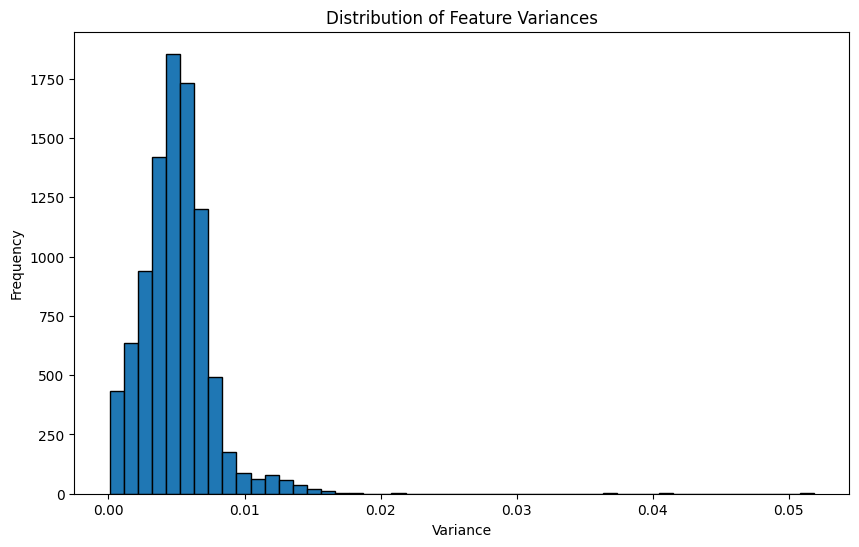

In [ ]:
def get_feature_and_label(df):
    ec_cols = [col for col in df.columns if col.startswith('ec_')]
    return df.drop(columns=ec_cols), df[ec_cols]

train_X, train_Y = get_feature_and_label(train_df)

scaler = MinMaxScaler()
scaler.fit(train_X)
train_X = scaler.transform(train_X).astype(np.float32)
variances = np.var(train_X, axis=0)

plt.figure(figsize=(10, 6))
plt.hist(variances, bins=50, edgecolor='k')
plt.xlabel('Variance')
plt.ylabel('Frequency')
plt.title('Distribution of Feature Variances')
plt.savefig('../metrics/feature_selection_results/training_var_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

In [42]:
thresholds = [0.0001, 0.0005, 0.001, 0.005, 0.01]
for t in thresholds:
    n_remaining = np.sum(variances > t)
    print(f"Threshold: {t}, features remaining: {n_remaining}")

Threshold: 0.0001, features remaining: 9252
Threshold: 0.0005, features remaining: 9152
Threshold: 0.001, features remaining: 8888
Threshold: 0.005, features remaining: 4437
Threshold: 0.01, features remaining: 319
